In [1]:
import torch
from pathlib import Path
from pseudotime import *
from LightningModules import FUCCIDataModule
import seaborn as sns
import pandas as pd
# This library shouldn't really care about the dataset being used
# It should be able to take batches of data and calculate their statistics
# and store them. Then run the pseudotime algorithm on the stored statistics

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# DATA_DIR = Path('/home/ishang/implicit-cell-model/FUCCI-dev-data')
DATA_DIR = Path('/data/ishang/Fucci-dataset-v3_filtered/')
imsize = 256
datamodule = FUCCIDataModule(DATA_DIR, "fucci", split=(1.0, 0.0, 0.0), imsize=imsize, batch_size=100, num_workers=1)

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


tensor(-inf) tensor(11.0903)


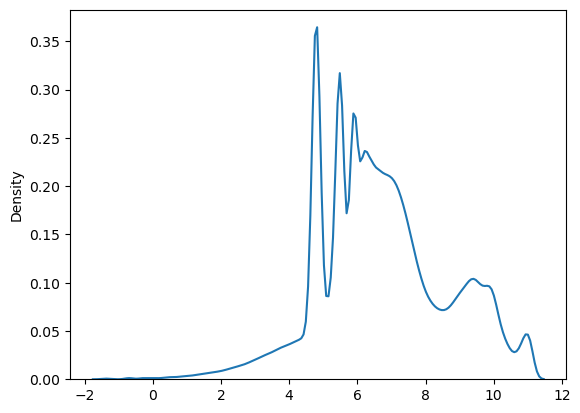

In [4]:
batch = next(iter(datamodule.train_dataloader()))
intensities = torch.log(batch.flatten())
sns.kdeplot(intensities)
print(intensities.min(), intensities.max())

In [23]:
FUCCI_intensities, FUCCI_intensities_norm = [], []
FUCCI_mins, FUCCI_maxes = [], []
for batch in iter(datamodule.train_dataloader()):
    flattened = batch.flatten(start_dim=2)
    mins = torch.min(torch.min(flattened, dim=2).values, dim=0, keepdim=True).values
    maxes = torch.max(torch.max(flattened, dim=2).values, dim=0, keepdim=True).values
    intensities = torch.sum(batch, dim=(2, 3))
    intensities_norm = (intensities - mins) / (maxes - mins + 1e-6)
    FUCCI_intensities.append(intensities)
    FUCCI_intensities_norm.append(intensities_norm)
    FUCCI_mins.append(mins)
    FUCCI_maxes.append(maxes)
FUCCI_intensities = torch.cat(FUCCI_intensities, dim=0)
FUCCI_intensities_norm = torch.cat(FUCCI_intensities_norm, dim=0)
FUCCI_mins = torch.cat(FUCCI_mins, dim=0)
FUCCI_maxes = torch.cat(FUCCI_maxes, dim=0)
print(FUCCI_intensities.shape)

torch.Size([55777, 2])


<Axes: ylabel='Count'>

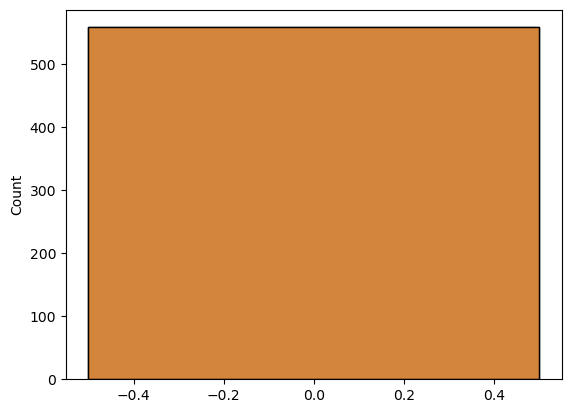

In [24]:
sns.histplot(FUCCI_mins[:, 0])
sns.histplot(FUCCI_mins[:, 1])

<Axes: ylabel='Count'>

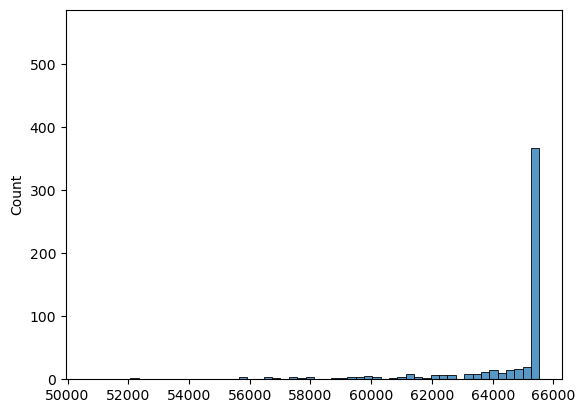

In [32]:
sns.histplot(FUCCI_maxes[:, 0])
sns.histplot(FUCCI_maxes[:, 1])

<Axes: xlabel='GMNN', ylabel='CDT1'>

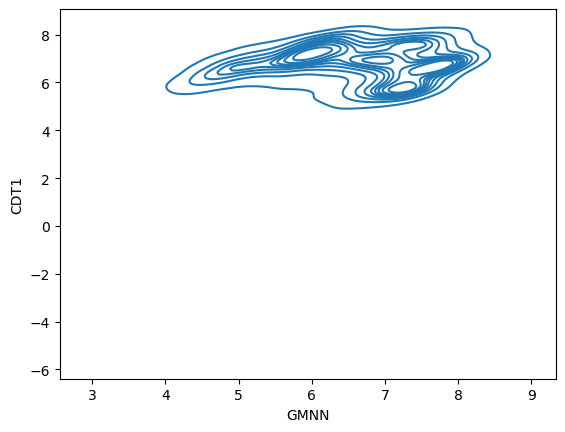

In [30]:
# plot the intensities as a scatter plot
fucci_df = pd.DataFrame(np.log10(FUCCI_intensities.numpy() + 1e-6), columns=['GMNN', 'CDT1'])
sns.kdeplot(data=fucci_df, x='GMNN', y='CDT1')

<Axes: xlabel='GMNN', ylabel='CDT1'>

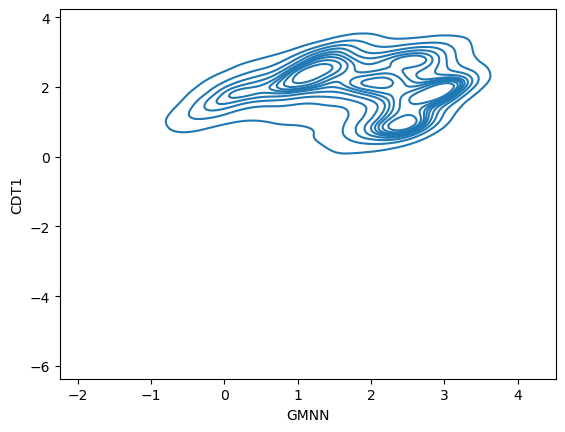

In [31]:
fucci_df_norm = pd.DataFrame(np.log10(FUCCI_intensities_norm.numpy() + 1e-6), columns=['GMNN', 'CDT1'])
sns.kdeplot(data=fucci_df_norm, x='GMNN', y='CDT1')

/tmp/ipykernel_1283347/2520682374.py:1: RuntimeWarning: divide by zero encountered in log10
  fucci_df_norm = pd.DataFrame(np.log10(FUCCI_intensities_norm.numpy()), columns=['GMNN', 'CDT1'])


<Axes: xlabel='GMNN', ylabel='CDT1'>

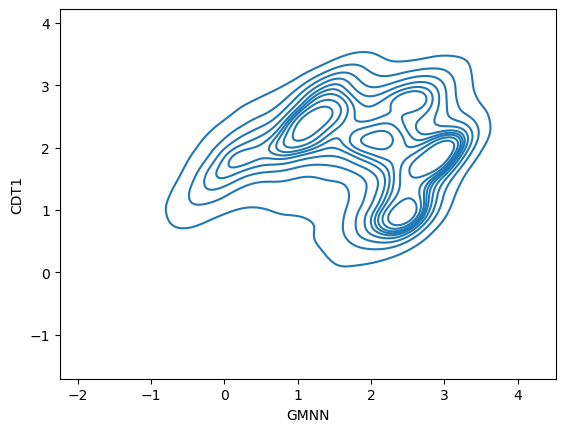

In [33]:
fucci_df_norm = pd.DataFrame(np.log10(FUCCI_intensities_norm.numpy()), columns=['GMNN', 'CDT1'])
sns.kdeplot(data=fucci_df_norm, x='GMNN', y='CDT1')

torch.Size([27888, 2])
tensor(17)
tensor(False)


/tmp/ipykernel_1283347/2416128150.py:14: RuntimeWarning: divide by zero encountered in log
  sns.kdeplot(x=np.log(X_train[:, 0]), y=np.log(X_train[:, 1]))


<Axes: >

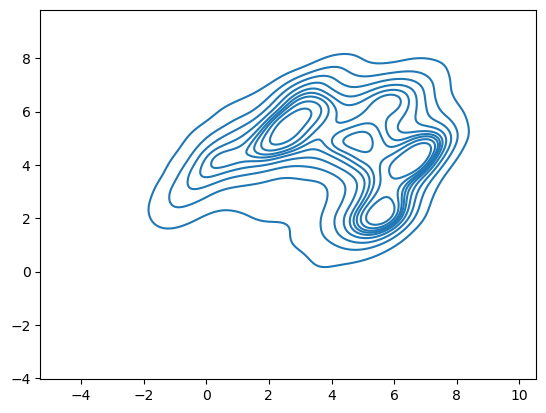

In [76]:
from sklearn import mixture
indices = torch.randperm(len(FUCCI_intensities_norm))
X_train = FUCCI_intensities_norm[indices[:len(FUCCI_intensities_norm) // 2]]
print(X_train.shape)
clf_cc = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
clf_cc_log = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
clf_batch = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
print(torch.isinf(torch.log(X_train)).sum())
print(torch.isinf(torch.nan_to_num(torch.log(X_train), neginf=-4).sum()))
log_fn = lambda x: torch.nan_to_num(torch.log(x), neginf=-4)
clf_cc.fit(X_train)
clf_cc_log.fit(log_fn(X_train))
clf_batch.fit(log_fn(X_train))
sns.kdeplot(x=np.log(X_train[:, 0]), y=np.log(X_train[:, 1]))

/tmp/ipykernel_1283347/2461057530.py:3: RuntimeWarning: divide by zero encountered in log
  sns.kdeplot(x=np.log(X_pred[:, 0]), y=np.log(X_pred[:, 1]), hue=y, palette="Set2")


<Axes: >

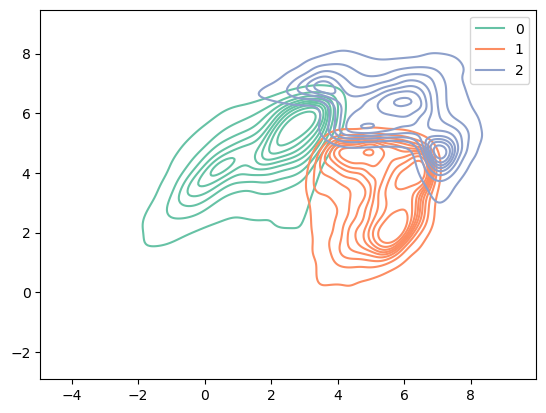

In [77]:
X_pred = FUCCI_intensities_norm[indices[len(FUCCI_intensities_norm) // 2:]]
y = clf_cc.predict(X_pred)
sns.kdeplot(x=np.log(X_pred[:, 0]), y=np.log(X_pred[:, 1]), hue=y, palette="Set2")

/tmp/ipykernel_1283347/1014164493.py:3: RuntimeWarning: divide by zero encountered in log
  sns.kdeplot(x=np.log(X_pred[:, 0]), y=np.log(X_pred[:, 1]), hue=y, palette="Set2")


<Axes: >

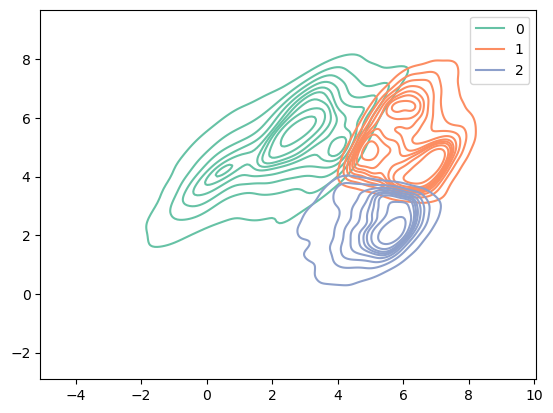

In [78]:
X_pred = FUCCI_intensities_norm[indices[len(FUCCI_intensities_norm) // 2:]]
y = clf_cc_log.predict(log_fn(X_pred))
sns.kdeplot(x=np.log(X_pred[:, 0]), y=np.log(X_pred[:, 1]), hue=y, palette="Set2")
# gmm_df = pd.DataFrame(np.log10(X_pred), columns=["GMNN", "CDT1"])
# gmm_df['label'] = y
# sns.scatterplot(data=gmm_df, x="GMNN", y="CDT1", hue="label", palette="Set2")
# sns.kdeplot(data=gmm_df, x="GMNN", y="CDT1")

/tmp/ipykernel_1283347/2093876462.py:2: RuntimeWarning: divide by zero encountered in log
  sns.kdeplot(x=np.log(X_pred[:, 0]), y=np.log(X_pred[:, 1]), hue=y, palette="Set2")


<Axes: >

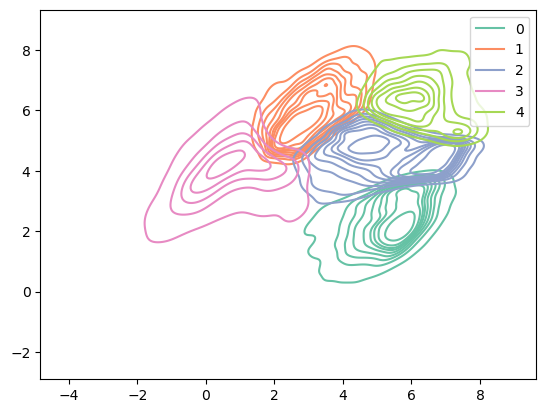

In [79]:
y = clf_batch.predict(log_fn(X_pred))
sns.kdeplot(x=np.log(X_pred[:, 0]), y=np.log(X_pred[:, 1]), hue=y, palette="Set2")